# Activation Pattern Analysis

How to visualize and analyze neuron activation patterns to understand what different neurons learn to recognize ?

Dataset used -> MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def get_layer_activations(self, x, layer_name):
        x = x.view(-1, 784)
        activations = {}

        x = F.relu(self.fc1(x))
        if layer_name == 'fc1':
            activations['fc1'] = x.clone()

        x = F.relu(self.fc2(x))
        if layer_name == 'fc2':
            activations['fc2'] = x.clone()

        x = F.relu(self.fc3(x))
        if layer_name == 'fc3':
            activations['fc3'] = x.clone()

        x = self.fc4(x)
        if layer_name == 'fc4':
            activations['fc4'] = x.clone()

        return activations.get(layer_name, None)

In [3]:
# Load MNIST data
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

100.0%

100.0%

100.0%

100.0%



In [4]:
def train_model(model, train_loader, epochs=10):
    """Train the MNIST model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if epoch % 2 == 0:
            print(f'Epoch {epoch}, Average Loss: {total_loss/len(train_loader):.4f}')
    
    print("Training completed!")

## Activation Heatmap Analysis

Create heatmaps showing which neurons activate for which digits.

In [5]:
def create_activation_heatmap(model, data_loader, layer_name='fc2', max_samples=1000):
    """Create heatmap showing which neurons activate for which digits"""
    model.eval()
    
    # Collect activations for each digit
    digit_activations = {i: [] for i in range(10)}
    sample_count = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            if sample_count >= max_samples:
                break
                
            activations = model.get_layer_activations(data, layer_name)
            
            for digit in range(10):
                digit_mask = (target == digit)
                if digit_mask.sum() > 0:
                    digit_data_activations = activations[digit_mask]
                    digit_activations[digit].append(digit_data_activations.mean(dim=0))
            
            sample_count += data.size(0)
    
    # Average activations per digit
    avg_activations = []
    for digit in range(10):
        if digit_activations[digit]:
            avg_act = torch.stack(digit_activations[digit]).mean(dim=0)
            avg_activations.append(avg_act.cpu().numpy())
        else:
            layer_size = model.get_layer_activations(data[:1], layer_name).size(1)
            avg_activations.append(np.zeros(layer_size))
    
    activation_matrix = np.array(avg_activations)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(activation_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Average Activation')
    plt.xlabel('Neuron Index')
    plt.ylabel('Digit Class')
    plt.title(f'Neuron Activation Patterns by Digit ({layer_name})')
    plt.yticks(range(10), [f'Digit {i}' for i in range(10)])
    plt.tight_layout()
    plt.show()
    
    return activation_matrix

In [6]:
def analyze_neuron_specialization(activation_matrix):
    """Analyze which neurons are most specialized for specific digits"""
    # Find neurons with highest activation for each digit
    most_active_neurons = {}
    
    for digit in range(10):
        top_neurons = np.argsort(activation_matrix[digit])[-5:][::-1]  # Top 5 neurons
        most_active_neurons[digit] = top_neurons
        print(f"Digit {digit} - Top neurons: {top_neurons}")
        print(f"  Activations: {activation_matrix[digit][top_neurons]}")
    
    # Find most specialized neurons (high activation for one digit, low for others)
    specialization_scores = []
    n_neurons = activation_matrix.shape[1]
    
    for neuron_idx in range(n_neurons):
        activations = activation_matrix[:, neuron_idx]
        max_activation = np.max(activations)
        mean_activation = np.mean(activations)
        
        # Specialization = max activation / mean activation
        if mean_activation > 0:
            specialization = max_activation / mean_activation
        else:
            specialization = 0
        
        specialization_scores.append(specialization)
    
    # Find most specialized neurons
    most_specialized = np.argsort(specialization_scores)[-10:][::-1]
    
    print("\nMost specialized neurons:")
    for i, neuron_idx in enumerate(most_specialized):
        best_digit = np.argmax(activation_matrix[:, neuron_idx])
        score = specialization_scores[neuron_idx]
        print(f"{i+1}. Neuron {neuron_idx}: specialized for digit {best_digit} (score: {score:.2f})")
    
    return most_active_neurons, specialization_scores

In [7]:
def visualize_neuron_activation_distribution(model, data_loader, layer_name='fc2', neuron_indices=[0, 1, 2, 3]):
    """Visualize activation distributions for specific neurons across all digits"""
    model.eval()
    
    # Collect activations for each digit
    digit_activations = {digit: {neuron: [] for neuron in neuron_indices} for digit in range(10)}
    
    with torch.no_grad():
        for data, target in data_loader:
            activations = model.get_layer_activations(data, layer_name)
            
            for digit in range(10):
                digit_mask = (target == digit)
                if digit_mask.sum() > 0:
                    digit_data_activations = activations[digit_mask]
                    
                    for neuron_idx in neuron_indices:
                        neuron_activations = digit_data_activations[:, neuron_idx].cpu().numpy()
                        digit_activations[digit][neuron_idx].extend(neuron_activations)
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, neuron_idx in enumerate(neuron_indices):
        ax = axes[i]
        
        for digit in range(10):
            if digit_activations[digit][neuron_idx]:
                ax.hist(digit_activations[digit][neuron_idx], alpha=0.5, 
                       label=f'Digit {digit}', bins=20, density=True)
        
        ax.set_title(f'Neuron {neuron_idx} Activation Distribution')
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

## Run Activation Analysis

In [8]:
# Train the model
model = MNISTNet()
print("Training model...")
train_model(model, train_loader, epochs=5)

# Test model accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Training model...
Epoch 0, Average Loss: 0.3199
Epoch 0, Average Loss: 0.3199
Epoch 2, Average Loss: 0.0802
Epoch 2, Average Loss: 0.0802
Epoch 4, Average Loss: 0.0452
Training completed!
Test Accuracy: 97.65%
Epoch 4, Average Loss: 0.0452
Training completed!
Test Accuracy: 97.65%


Creating activation heatmap...


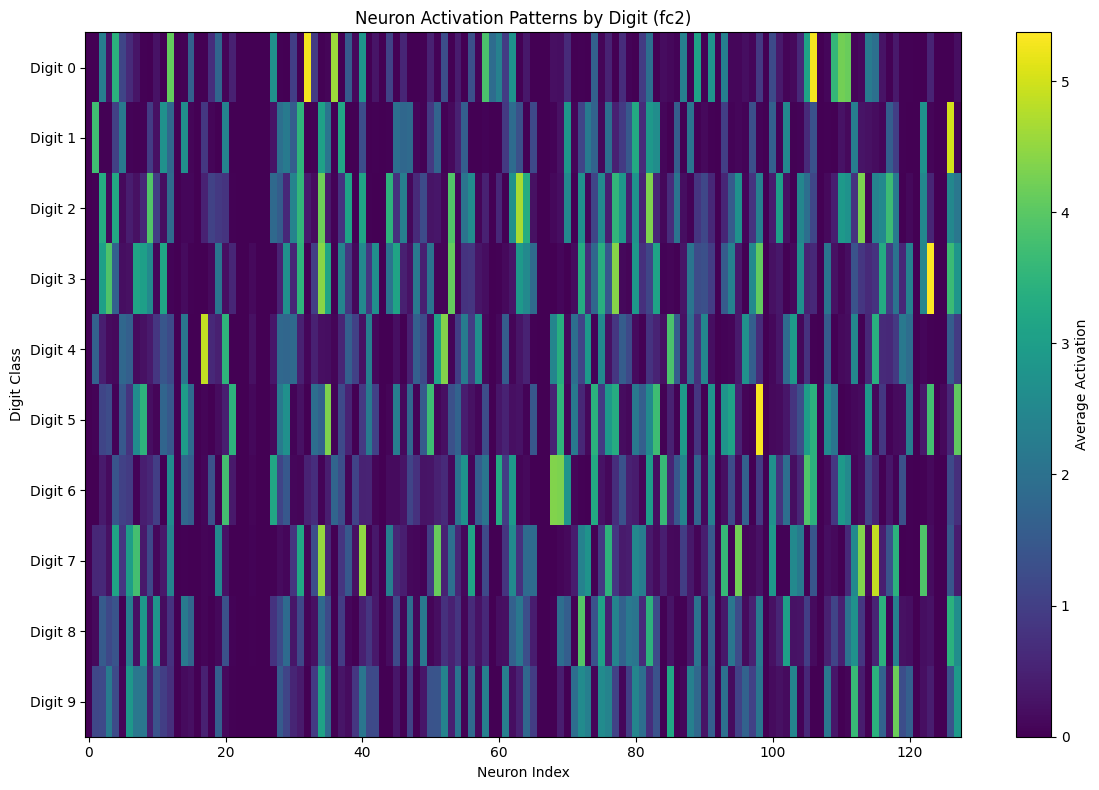

In [9]:
# Create activation heatmap
print("Creating activation heatmap...")
activation_matrix = create_activation_heatmap(model, test_loader, layer_name='fc2')

In [10]:
# Analyze neuron specialization
print("Analyzing neuron specialization...")
most_active, specialization_scores = analyze_neuron_specialization(activation_matrix)

Analyzing neuron specialization...
Digit 0 - Top neurons: [106  32  36 110 111]
  Activations: [5.300164  5.2786446 4.584847  4.2183213 4.142961 ]
Digit 1 - Top neurons: [126   1  31  80  37]
  Activations: [5.0270605 3.7255452 3.5169857 3.2693589 3.1688468]
Digit 2 - Top neurons: [ 63  82 113  34   9]
  Activations: [4.675414  4.3374248 4.3132706 4.187778  3.909051 ]
Digit 3 - Top neurons: [123  34  77  53  98]
  Activations: [5.3712564 4.4219685 4.3917603 4.0966763 4.0804486]
Digit 4 - Top neurons: [ 17  52  85  20 115]
  Activations: [4.8839755 4.375093  3.8586502 3.4834666 3.3874416]
Digit 5 - Top neurons: [ 98  35 127 123  50]
  Activations: [5.3096232 4.3233905 4.068097  3.7694821 3.7025433]
Digit 6 - Top neurons: [ 68  69 105  20  84]
  Activations: [4.3514047 4.311091  3.9013188 3.7727723 3.6257715]
Digit 7 - Top neurons: [115  34  40 113  95]
  Activations: [4.876579  4.5199637 4.480906  4.351675  4.2215867]
Digit 8 - Top neurons: [ 72  82 116 126  75]
  Activations: [3.924651

Visualizing distributions for neurons: [16 23 59 22]


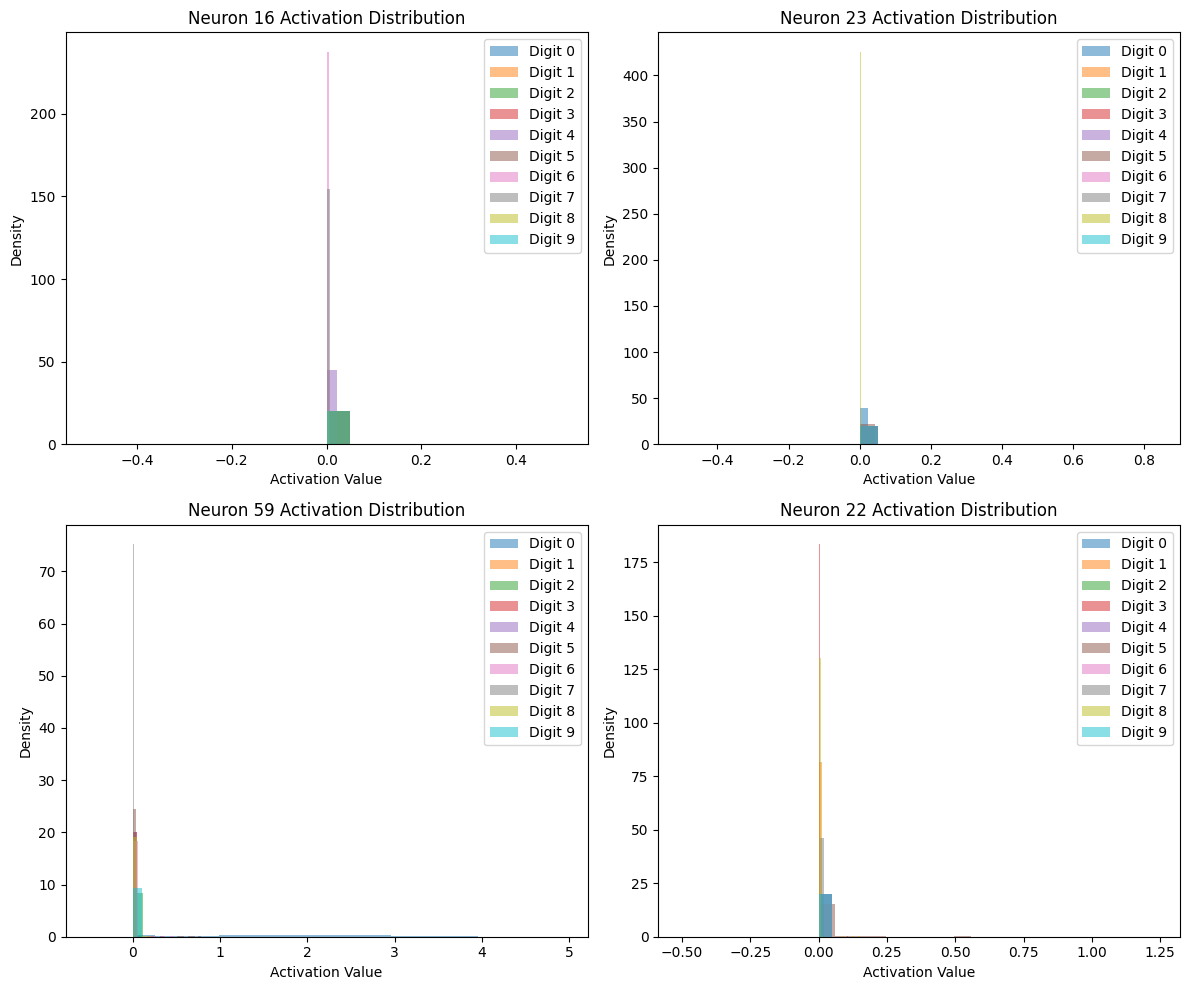

In [11]:
# Visualize activation distributions for most specialized neurons
most_specialized_indices = np.argsort(specialization_scores)[-4:][::-1]
print(f"Visualizing distributions for neurons: {most_specialized_indices}")
visualize_neuron_activation_distribution(model, test_loader, layer_name='fc2', 
                                       neuron_indices=most_specialized_indices)